# Урок 7. ГРАФИКИ, ДАШБОРДЫ И МОНИТОРИНГИ

### 1

Ваш менее опытный коллега не уверен, что его таблица retail действительно создалась и добавилась в базу данных. Напишите запрос, который создаст таблицу, если она еще не существует (IF NOT EXISTS), со следующими параметрами:

Название: `retail`  
База: test
Столбцы:
- InvoiceNo – идентификатор заказа, строковое значение

- StockCode – идентификатор товара, строковое значение

- Description – описание товара, строковое значение

- Quantity – количество единиц товара, добавленных в корзину (особенность данных – значения могут быть отрицательными, 32 бита)

- InvoiceDate – дата и время создания заказа (транзакции), часовой пояс – 'Europe/London'

- UnitPrice – цена за единицу товара (особенность данных – значения могут быть отрицательными, точность – три знака после точки, 64 бита)

- CustomerID – идентификатор пользователя, целое положительное число, 32 бита.

- Country – страна, строковое значение. 

Движок: MergeTree  
Сортировка: InvoiceDate, CustomerID


In [ ]:
CREATE TABLE IF NOT EXISTS test.retail ( 
    InvoiceNo String,
    StockCode String,
    Description String,
    Quantity Int32,
    InvoiceDate DateTime('Europe/London'),
    UnitPrice Decimal64(3),
    CustomerID UInt32,
    Country String 
    ) 

ENGINE = MergeTree
ORDER BY (InvoiceDate, CustomerID) 

### 2

В следующих шагах используется `default.retail` – данные о транзакциях британского интернет-магазина в период с 1 декабря 2010 по 9 декабря 2011, где:

- InvoiceNo – номер транзакции
- StockCode – код товара
- Description – описание товара
- Quantity – количество единиц товара, добавленных в заказ
- InvoiceDate – дата транзакции 
- UnitPrice – цена за единицу товара
- CustomerID – id клиента
- Country – страна, где проживает клиент

Для начала посмотрите, в каких странах имеется наибольшее число уникальных пользователей. Постройте барчарт, где:

- по оси x – страна
- по оси y – число пользователей  
В качестве ответа укажите число уникальных пользователей из Великобритании. 

In [ ]:
SELECT Country,
       COUNT(DISTINCT CustomerID) AS NumUsers
  FROM default.retail
 GROUP BY Country
 ORDER BY NumUsers DESC
 LIMIT 10

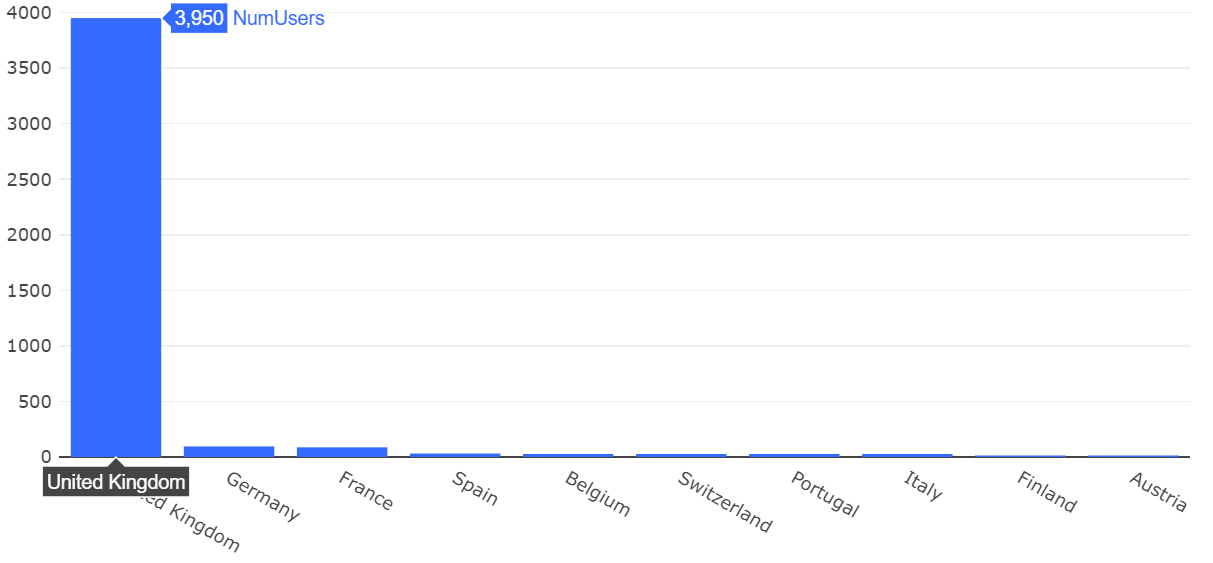

### 3

Следующая задача – посмотреть на динамику изменения числа активных пользователей в месяц в Великобритании, Австралии и Нидерландах. Полученная вами результирующая таблица должна иметь вид: страна - число уникальных пользователей за определённый месяц.

- MAU (monthly active users) – число уникальных пользователей за месяц. Активные пользователи – те, кто сделал хотя бы один заказ за выбранный промежуток времени (месяц).
В качестве ответа укажите наименьшее число пользователей за февраль 2011. 

In [ ]:
SELECT Country,
       toStartOfMonth(InvoiceDate) AS date,
       uniqExact(CustomerID) AS Customer
  FROM retail
 WHERE Country IN ('United Kingdom', 'Netherlands', 'Australia')
 GROUP BY date, Country
 ORDER BY Customer ASC

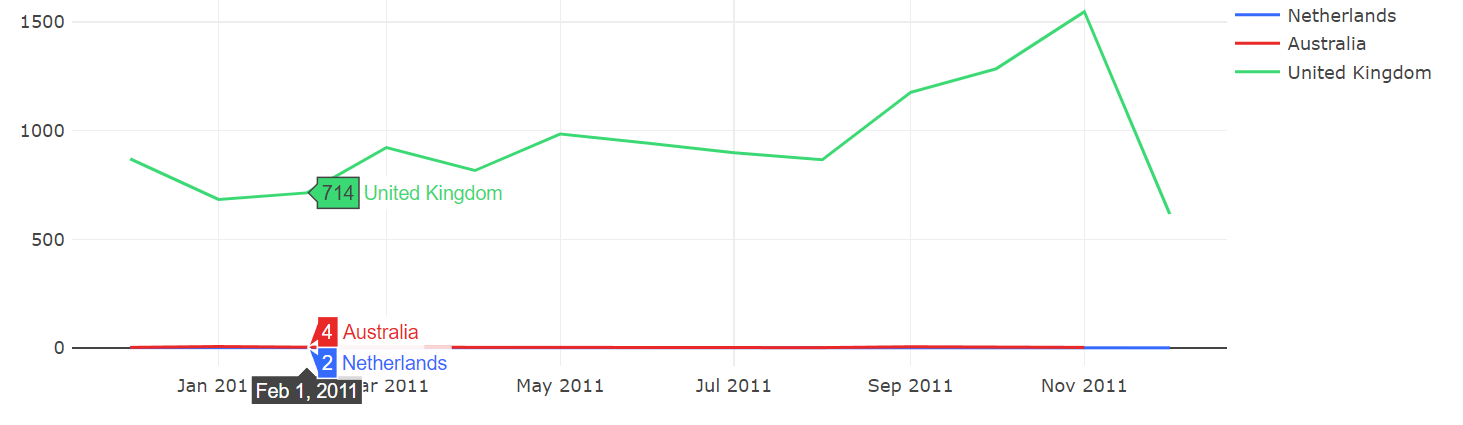

### 4

Как вы могли заметить, график с предыдущего шага получается не очень информативным для 2 из 3 стран. Давайте посмотрим на динамику изменения числа активных пользователей в месяц уже для всех стран, кроме Великобритании. 

В каких месяцах число активных пользователей во Франции было больше, чем в Германии?

__· Декабрь 2011__  
__· Май 2011__  
· Июнь 2011  
__· Сентябрь 2011__  
· Декабрь 2010  
· Всегда

In [ ]:
SELECT Country,
       toStartOfMonth(InvoiceDate) AS date,
       uniqExact(CustomerID) AS Customer
  FROM retail
 WHERE Country IN ('Germany', 'France')
 GROUP BY date, Country
 ORDER BY Customer ASC
 LIMIT 100

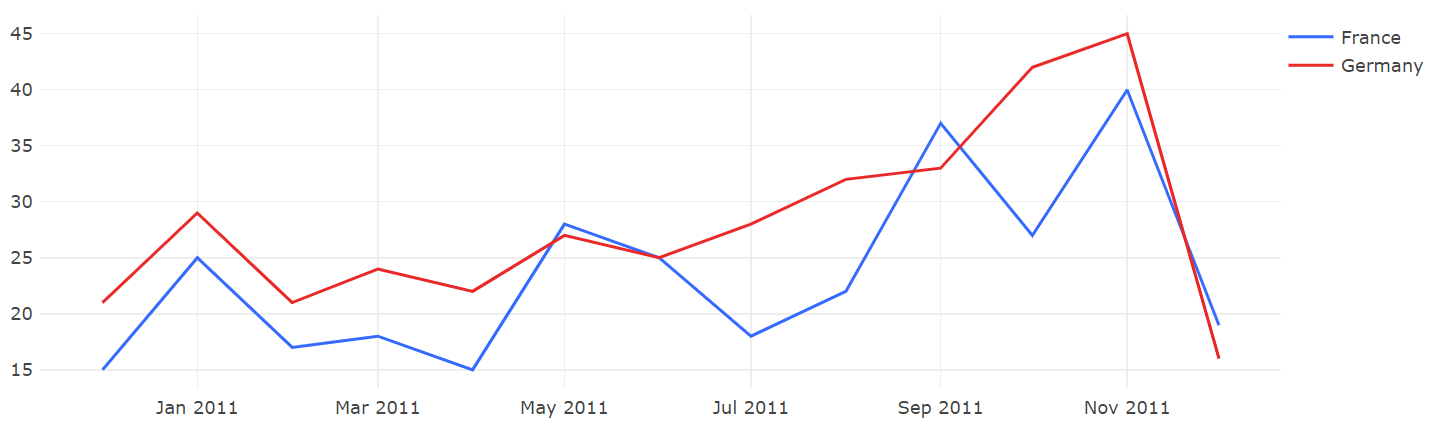

### 5

Теперь проанализируем сами заказы. Посчитайте среднюю сумму заказа (AOV – average order value) в каждой из стран.

Обратите внимание, что пользователь может добавить несколько одинаковых товаров в один заказ, и для подсчета суммы каждого заказа можно создать столбец TotalPrice, в котором будет храниться цена, которую пользователь заплатил, например, за три упаковки чая.

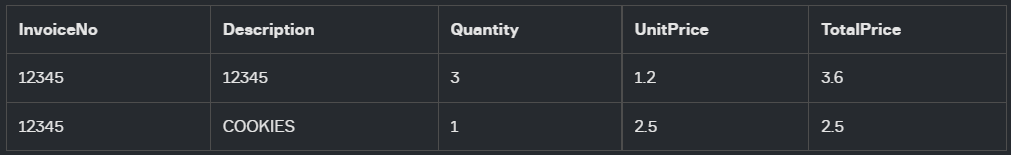

Далее для каждого заказа нужно просуммировать полученную колонку, а затем сгруппировать данные по странам и посчитать среднюю сумму заказа в каждой из них.

Визуализируйте результат. Из представленных вариантов ответа выберите страны, входящие в топ-3 по величине средней суммы заказа.

NB! В таблице есть отрицательные значения Quantity, что соответствует отмененным заказам. Их в расчет AOV включать не нужно.

__· Netherlands__    
· Sweden  
__· Singapore__    
· Japan  
__· Australia__    
· United Kingdom  

In [ ]:
SELECT Country,
       AVG(sum_order) AS avg_order
  FROM (SELECT Country,
               InvoiceNo,
               SUM(Quantity * UnitPrice) AS sum_order
          FROM retail
         WHERE Quantity > 0
         GROUP BY Country, InvoiceNo
       )
 GROUP BY Country

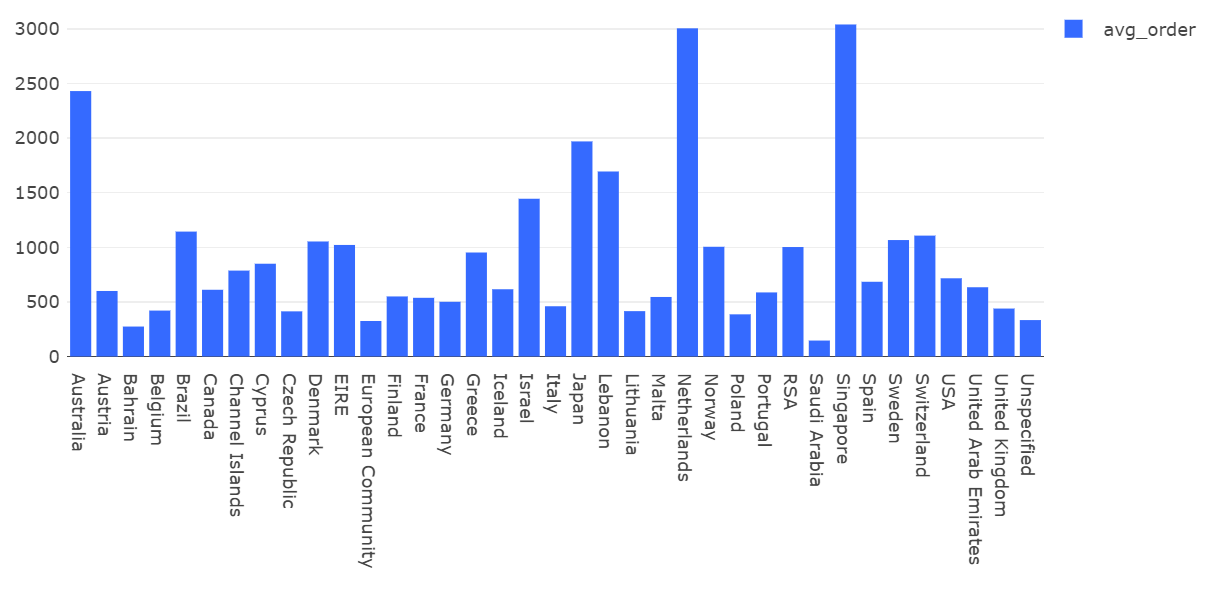

### 6

Как изменялась средняя сумма заказа в разных странах по месяцам?

Предположим, нас интересует динамика в следующих странах: United Kingdom, Germany, France, Spain, Netherlands, Belgium, Switzerland, Portugal, Australia, USA. Визуализируйте результат и выберите верные утверждения.

· Второй по размеру средний чек – в Германии  
__· Самые большие значения среднего чека наблюдаются в Австралии и Нидерландах.__    
__· Аномальный рост среднего чека произошел в августе 2011 среди пользователей из Австралии__    
__· Примерно до октября средний чек США постепенно рос__    
· Средний чек в Великобритании значительно выше, чем во всех других странах  
· Аномальный рост среднего чека произошел в июле 2011 среди пользователей из Австралии  

In [ ]:
SELECT Country,
       order_month,
       AVG(sum_order) AS avg_order
  FROM (SELECT Country,
               InvoiceNo,
               toStartOfMonth(InvoiceDate) as order_month,
               SUM(Quantity * UnitPrice) AS sum_order
          FROM retail
         WHERE Quantity > 0
         GROUP BY Country, InvoiceNo, order_month
       )
 WHERE Country IN ('United Kingdom', 'Germany', 'France', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 
                   'Australia', 'USA')
 GROUP BY Country, order_month
 ORDER BY Country

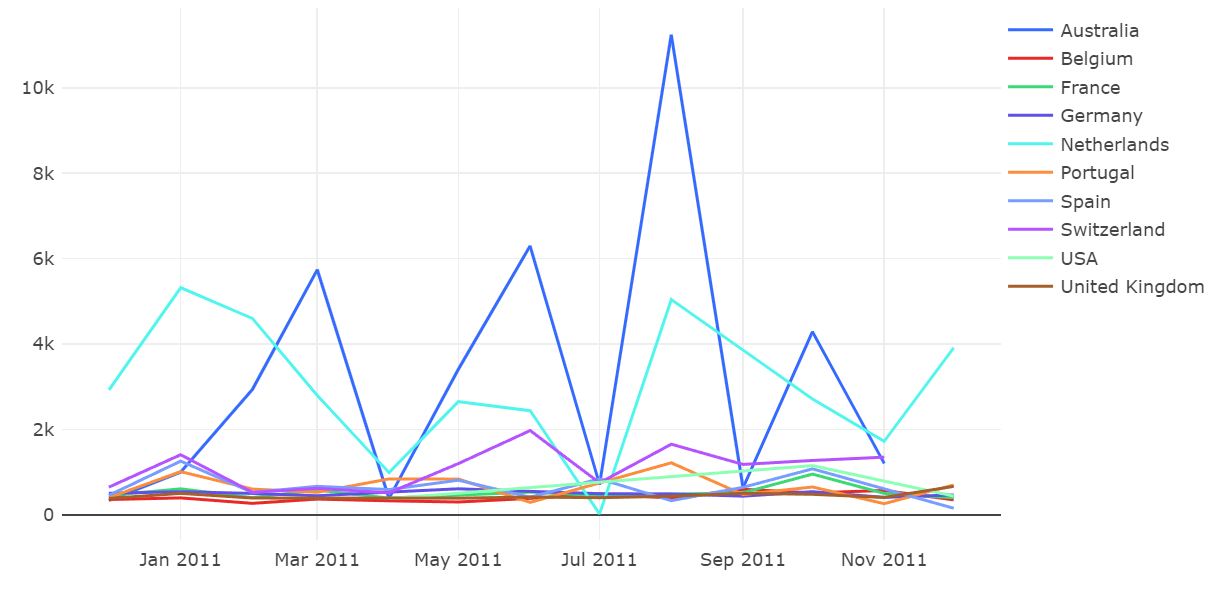

### 7

Сколько товаров пользователи обычно добавляют в корзину? Посчитайте среднее количество товаров, добавленных в корзину, с разбивкой по странам. 

В качестве ответа укажите среднее число товаров в заказе среди пользователей в Канаде (Canada). Разделитель - точка.

In [ ]:
SELECT Country,
       AVG(ItemsInOrder) AS AvgPerOrder
  FROM (SELECT Country,
               SUM(Quantity) AS ItemsInOrder
          FROM retail
         GROUP BY InvoiceNo, Country
       )
 WHERE Country = 'Canada'
 GROUP BY Country

### 8

Возможно, результат на предыдущем шаге показался вам странным, особенно если соотнести средний размер корзины с числом уникальных пользователей в некоторых странах. 

Посмотрим на Нидерланды (Netherlands) более подробно. Сгруппируйте данные по пользователям и посмотрите, кто купил наибольшее число товаров. В ответе укажите идентификатор данного пользователя. 

In [ ]:
SELECT CustomerID,
       SUM(Quantity) as NumItems
  FROM retail
 WHERE Country = 'Netherlands'
 GROUP BY CustomerID
 ORDER BY NumItems DESC
 LIMIT 1

### Задание на построение дашборда

Следующая задача: подготовить дашборд в Redash (состоящий из более чем четырх графиков). Есть несколько основных вариантов, и в обоих случаях вы можете дополнить его любыми графиками, которые кажутся вам интересными и полезными:

1. Построить дашборд для отдела продаж. Вывести основные показатели: например, выручку по странам, дням, топ товаров, и другие графики, которые вы считаете необходимыми для отражения текущего положения дел.
2. Самостоятельно поставить себе задачу :)  

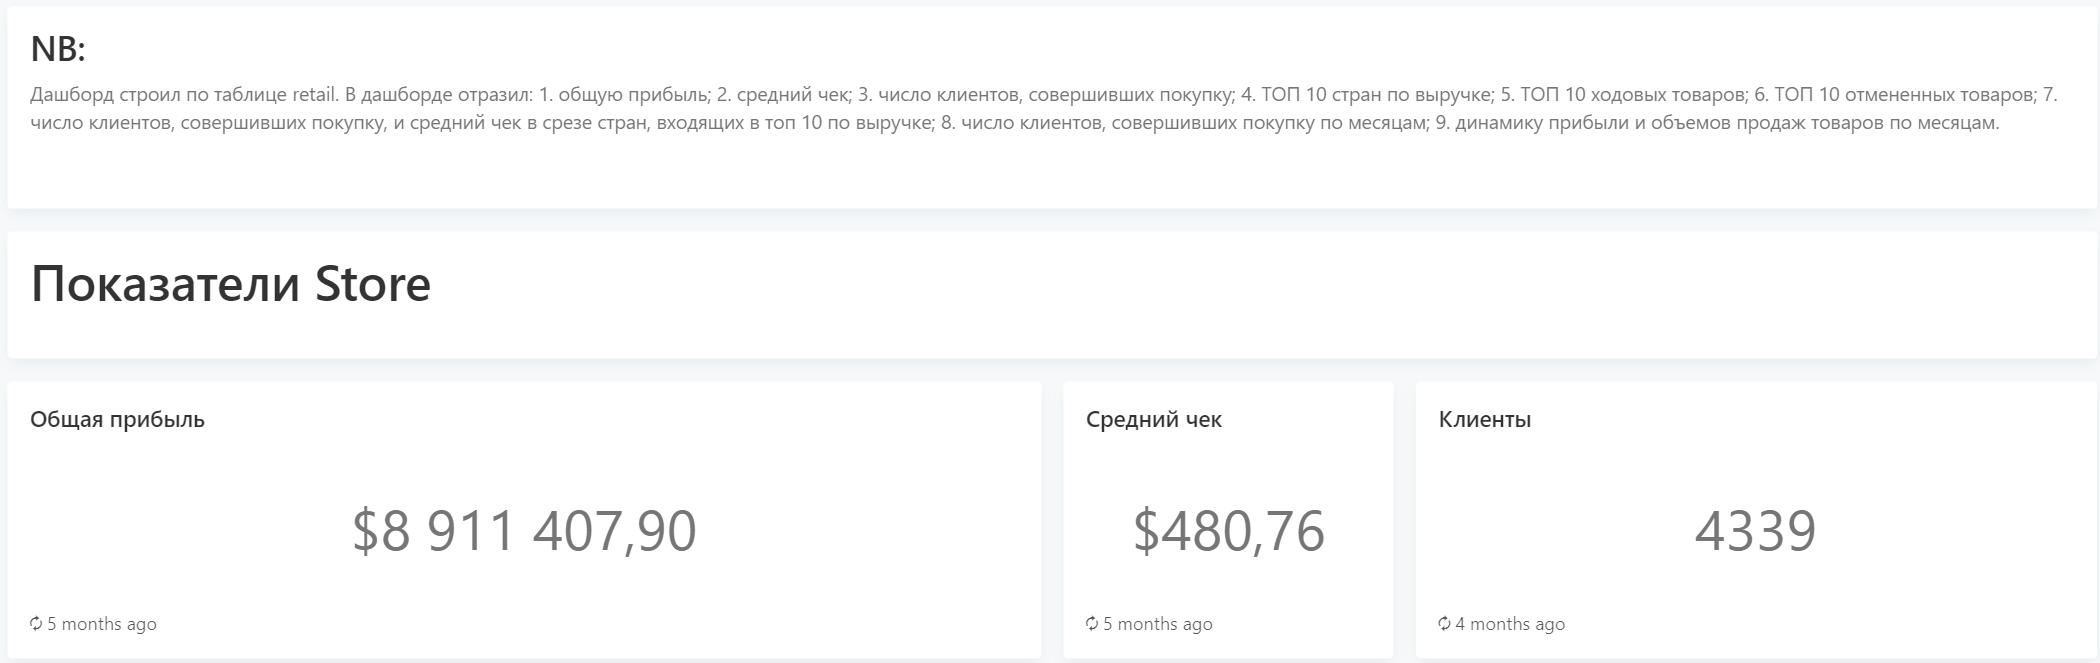

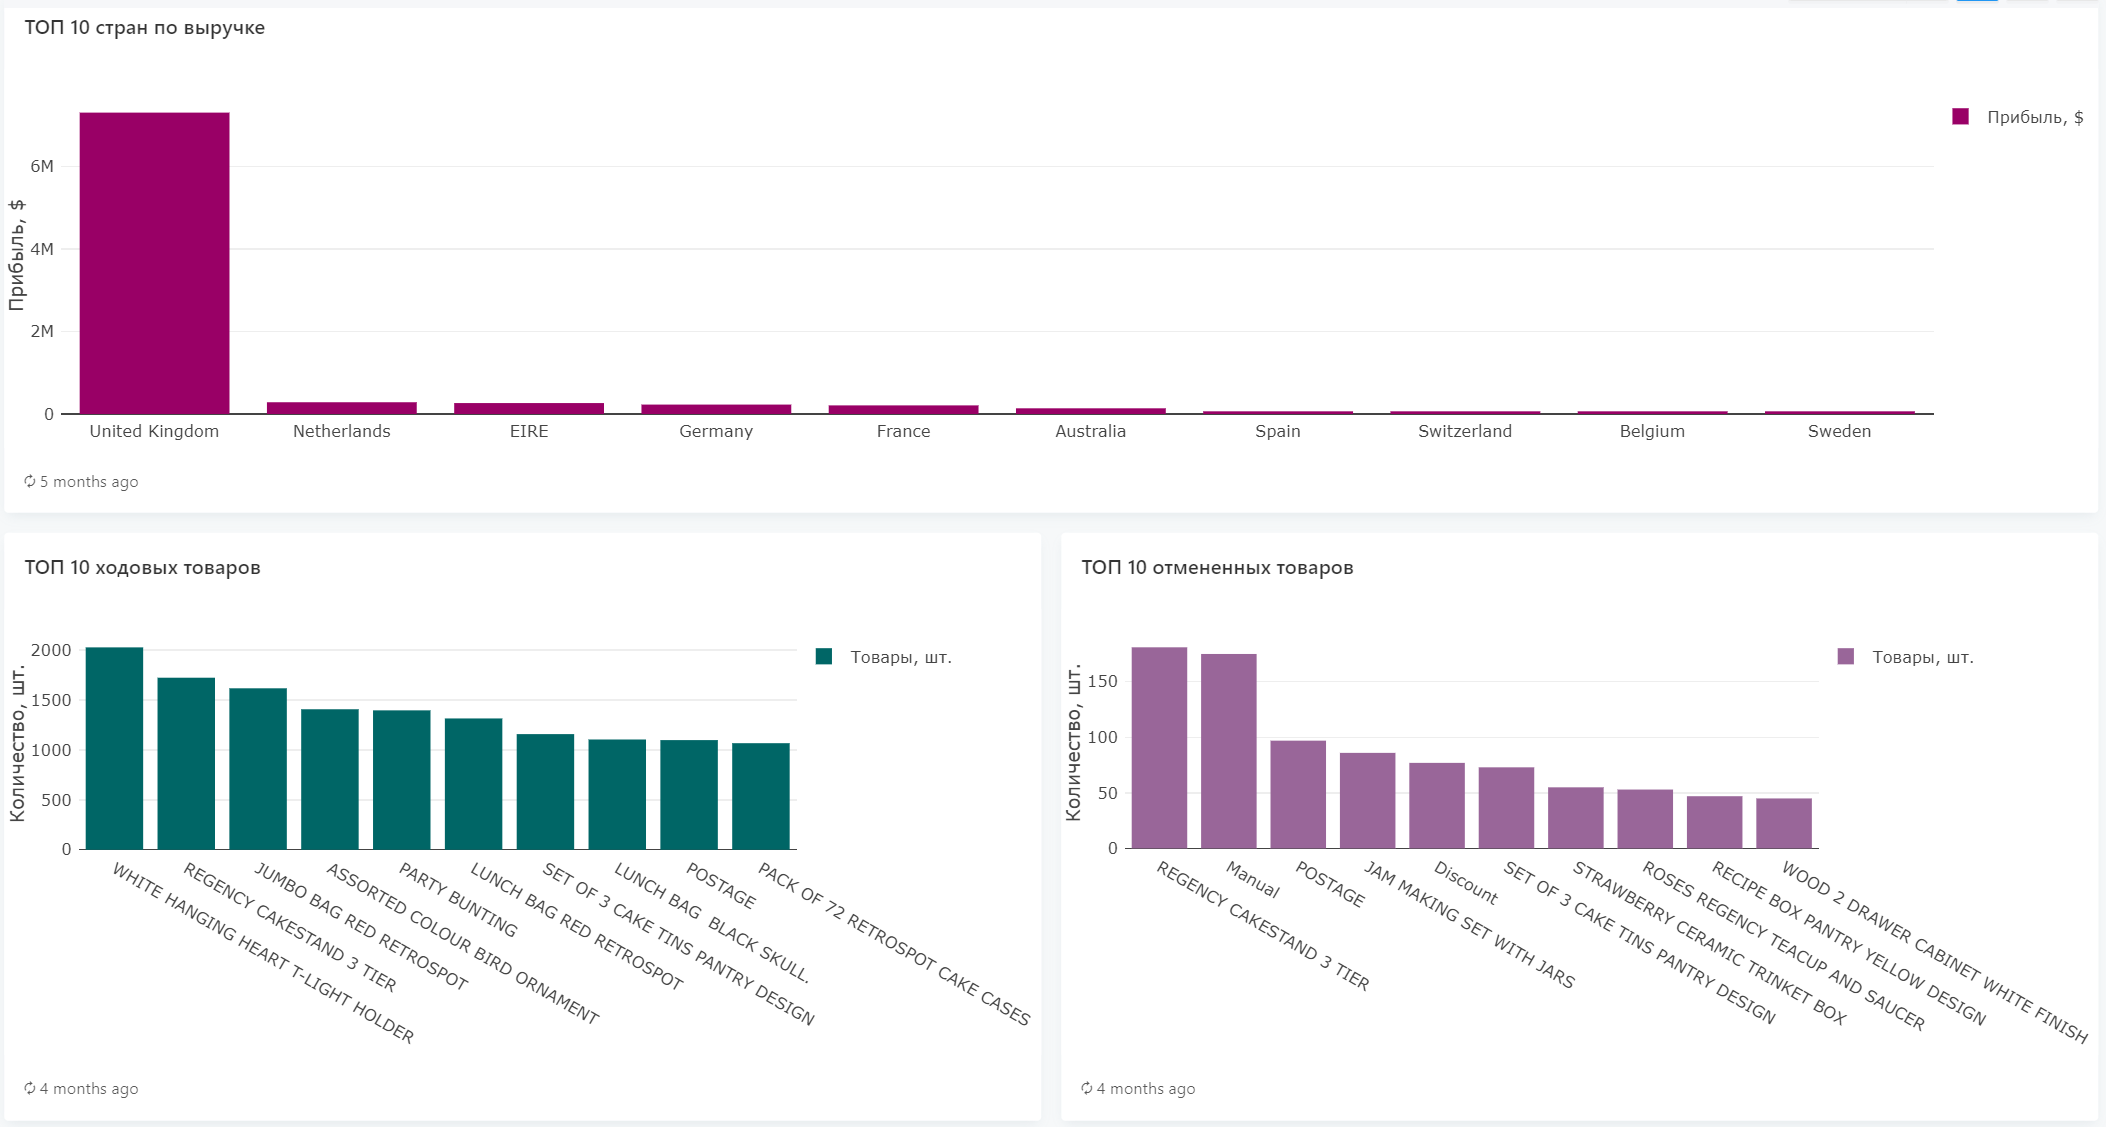

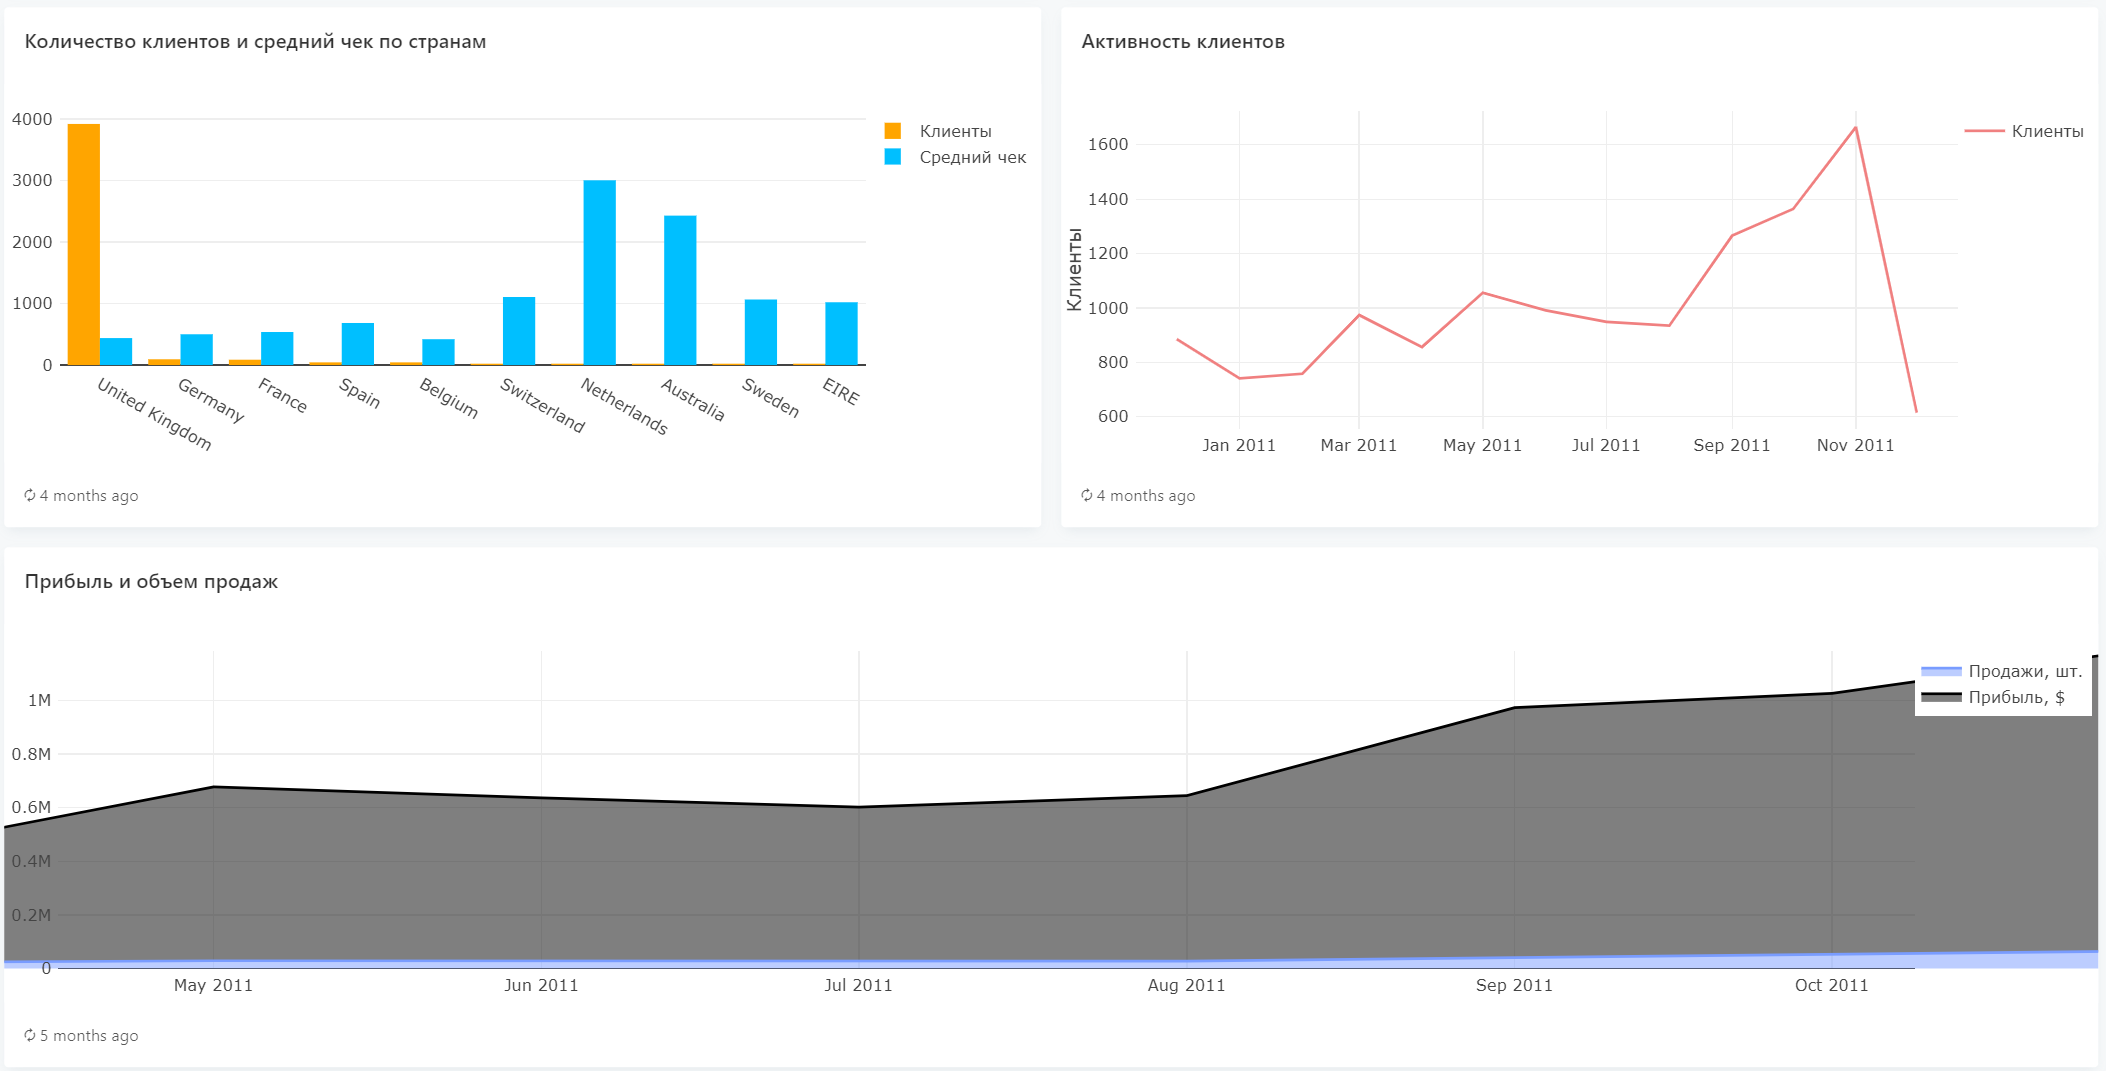